In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

In [2]:
# Calculate empirical variance from cybershake - ASK residuals
hazard_output_dir = '../hazard_outputs/400_training_eqs_2000_epochs_no_source/testing'
# hazard_output_dir = '../hazard_outputs/4179_training_eqs_500_epochs_no_source/training'
variance_df = pd.read_csv(os.path.join(hazard_output_dir, 'site_variances.csv'))
variance_df.head(2)

,site_id,site_name,site_lat,site_lon,model_vs30,Z1.0,Z2.5,class,ngmm_var,gmm_var,gmm_empirical_var
0,ACTN,Acton,34.46130,-118.18378,491.0,100,840,Precarious Rock,0.501699,0.480612,0.334772
1,ALIS,Aliso,34.41973,-118.09137,649.7,60,700,Precarious Rock,0.501672,0.480600,0.341943


In [3]:
# Each site has equal number of earthquakes, so we can just take the mean of all sites
gmm_empirical_var = np.mean(variance_df['gmm_empirical_var'])
print(f'GMM empirical variance: {gmm_empirical_var}')

GMM empirical variance: 0.49570391587403734


In [4]:
# Make new plots
# Define the sa to plot
ln_sa_values = np.log(np.linspace(0.01, 3, 1000))
overwrite = False
for site_id in tqdm(variance_df['site_id'], total=len(variance_df),
                    desc='Processing sites'):
    prediction_dir = os.path.join(hazard_output_dir, site_id)
    if not overwrite and (
        os.path.exists(os.path.join(prediction_dir, "hazard_curve_v2.csv")) and
        os.path.exists(os.path.join(prediction_dir, "hazard_curve_v2.png"))
    ):
        continue
    ngmm_poe_values = np.zeros_like(ln_sa_values)
    gmm_poe_values = np.zeros_like(ln_sa_values)
    ngmm_alea_only_poe_values = np.zeros_like(ln_sa_values)
    cybershake_training_rup_var_poe_values = np.zeros_like(ln_sa_values)
    predictions_df = pd.read_csv(os.path.join(
        prediction_dir, 'predictions.csv'))
    for i, row in predictions_df.iterrows():
        gmm_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=np.log(row['gmm_mean']), 
            scale=np.sqrt(gmm_empirical_var))
        )

        ngmm_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=np.log(row['gmm_mean'])+row['mean'],
            scale=np.sqrt(row['variance_with_noise']))     
        )

        ngmm_alea_only_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=np.log(row['gmm_mean'])+row['mean'],
            scale=np.sqrt(row['variance_with_noise'] - row['variance']))
        )
        cybershake_training_rup_var_poe_values += row['probability'] * (
            (np.log(row['gmm_mean']) + row['cybershake_res'] > ln_sa_values).astype(float)
        )
    # Save the hazard curves
    hazard_curve_df = pd.DataFrame({
        'ln_sa': ln_sa_values,
        'gmm_poe': gmm_poe_values,
        'ngmm_poe': ngmm_poe_values,
        'ngmm_alea_only_poe': ngmm_alea_only_poe_values,
        'cybershake_training_rup_var_poe': cybershake_training_rup_var_poe_values
    })
    hazard_curve_df.to_csv(os.path.join(prediction_dir, "hazard_curve_v2.csv"), index = False)
    # Plot and save the hazard curves
    fig, ax = plt.subplots(figsize=(4,3))
    ax.plot(np.exp(ln_sa_values), ngmm_poe_values, label='NGMM')
    ax.plot(np.exp(ln_sa_values), ngmm_alea_only_poe_values, label='NGMM (Aleatory only)')
    ax.plot(np.exp(ln_sa_values), gmm_poe_values, label='GMM (Empirical Variance)')
    ax.plot(np.exp(ln_sa_values), cybershake_training_rup_var_poe_values, label='Cybershake (Training ruptures)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_xlabel('Spectral Acceleration 2.0 (g)')
    ax.set_ylabel('Annual Probability of Exceedance')
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    ax.set_title(f'Site {site_id}')
    ax.set_ylim([1e-6, 1e-1])
    fig.savefig(os.path.join(prediction_dir, "hazard_curve_v2.png"), bbox_inches='tight', dpi=300)
    plt.close(fig)

Processing sites: 100%|██████████| 335/335 [00:00<00:00, 1608.18it/s]


In [2]:
# Compare
hazard_output_400_dir = '../hazard_outputs/400_training_eqs_2000_epochs_no_source/testing'
variance_400_df = pd.read_csv(os.path.join(hazard_output_400_dir, 'site_variances.csv'))
hazard_output_4179_dir = '../hazard_outputs/4179_training_eqs_500_epochs_no_source/testing'
variance_4179_df = pd.read_csv(os.path.join(hazard_output_4179_dir, 'site_variances.csv'))
compare_dir = '../hazard_outputs/compare_400_4179_eqs/testing'
os.makedirs(compare_dir, exist_ok=True)

In [8]:
# Make median for several sites
site_ids = ['s399', 's153', 's433', 'PLS']
# site_ids = ['PLS']
for site_id in tqdm(site_ids, total =len(site_ids), desc='Calculate median hazard curves'):
    prediction_400_dir = os.path.join(hazard_output_400_dir, site_id)
    predictions_400_df = pd.read_csv(os.path.join(
        prediction_400_dir, 'predictions.csv'))
    print(site_id, 'Prediction mean (400 training eqs)', predictions_400_df['mean'].mean())
    prediction_4179_dir = os.path.join(hazard_output_4179_dir, site_id)
    predictions_4179_df = pd.read_csv(os.path.join(
        prediction_4179_dir, 'predictions.csv'))
    print(site_id, 'Prediction mean (4179 training eqs)', predictions_4179_df['mean'].mean())
    ln_sa_values = np.log(np.linspace(0.01, 3, 1000))
    ngmm_no_noise_poe_values_400 = np.zeros_like(ln_sa_values)
    ngmm_no_noise_poe_values_4179 = np.zeros_like(ln_sa_values)
    cybershake_poe_values = np.zeros_like(ln_sa_values)
    gmm_no_noise_poe_values = np.zeros_like(ln_sa_values)
    for i, row in predictions_400_df.iterrows():
        cybershake_mean = np.log(row['gmm_mean']) + row['cybershake_res']
        cybershake_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=cybershake_mean, scale=0.0001))
        ngmm_mean = np.log(row['gmm_mean']) + row['mean']
        ngmm_no_noise_poe_values_400 += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=ngmm_mean, scale=0.0001))
        gmm_no_noise_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=np.log(row['gmm_mean']), scale=0.0001))
    for i, row in predictions_4179_df.iterrows():
        ngmm_mean = np.log(row['gmm_mean']) + row['mean']
        ngmm_no_noise_poe_values_4179 += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=ngmm_mean, scale=0.0001))

    fig, ax = plt.subplots(figsize=(4,3))
    ax.plot(np.exp(ln_sa_values), ngmm_no_noise_poe_values_400, '--', label='NGMM (400 training EQs)')
    ax.plot(np.exp(ln_sa_values), ngmm_no_noise_poe_values_4179, '--', label='NGMM (4179 training EQs)')
    ax.plot(np.exp(ln_sa_values), cybershake_poe_values, 'k-', label='CyberShake')
    ax.plot(np.exp(ln_sa_values), gmm_no_noise_poe_values, 'k--', label='GMM')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_xlabel('Spectral Acceleration 2.0 (g)')
    ax.set_ylabel('Annual Probability of Exceedance')
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    # ax.set_title(f'Site {site_id}')
    ax.set_ylim([1e-4, 1e-1])
    ax.set_xlim([1e-2, 2])
    save_path = os.path.join(compare_dir, f'median_hazard_curve_compare_{site_id}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)

Calculate median hazard curves:   0%|          | 0/4 [00:00<?, ?it/s]

s399 Prediction mean (400 training eqs) -0.06572811065174988
s399 Prediction mean (4179 training eqs) -0.1130924084277685


Calculate median hazard curves:  25%|██▌       | 1/4 [00:02<00:07,  2.58s/it]

s153 Prediction mean (400 training eqs) 0.23780534799408726
s153 Prediction mean (4179 training eqs) 0.299318279997101


Calculate median hazard curves:  50%|█████     | 2/4 [00:04<00:04,  2.06s/it]

s433 Prediction mean (400 training eqs) 0.4248893348741342
s433 Prediction mean (4179 training eqs) 0.4640065318938861


Calculate median hazard curves:  75%|███████▌  | 3/4 [00:06<00:02,  2.00s/it]

PLS Prediction mean (400 training eqs) -0.31401559058686
PLS Prediction mean (4179 training eqs) -0.37990178359106863


Calculate median hazard curves: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Calculate median hazard curves:   0%|          | 0/1 [00:00<?, ?it/s]

s399 Prediction mean (400 training eqs) -0.06572811065174988
s399 Prediction mean (4179 training eqs) -0.1130924084277685


Calculate median hazard curves: 100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


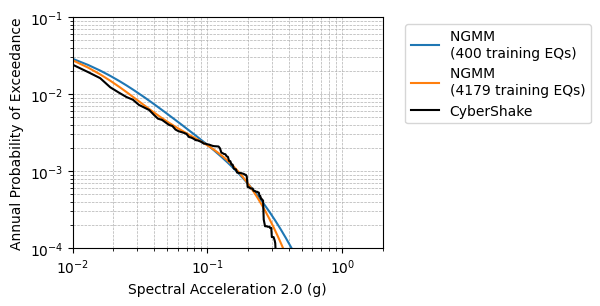

In [ ]:
# Make median for several sites
site_ids = ['s399', 's153', 's433', 'PLS']
# site_ids = ['s399']
for site_id in tqdm(site_ids, total =len(site_ids), desc='Calculate median hazard curves'):
    prediction_400_dir = os.path.join(hazard_output_400_dir, site_id)
    predictions_400_df = pd.read_csv(os.path.join(
        prediction_400_dir, 'predictions.csv'))
    print(site_id, 'Prediction mean (400 training eqs)', predictions_400_df['mean'].mean())
    prediction_4179_dir = os.path.join(hazard_output_4179_dir, site_id)
    predictions_4179_df = pd.read_csv(os.path.join(
        prediction_4179_dir, 'predictions.csv'))
    print(site_id, 'Prediction mean (4179 training eqs)', predictions_4179_df['mean'].mean())
    ln_sa_values = np.log(np.linspace(0.01, 3, 1000))
    ngmm_no_noise_poe_values_400 = np.zeros_like(ln_sa_values)
    ngmm_no_noise_poe_values_4179 = np.zeros_like(ln_sa_values)
    cybershake_poe_values = np.zeros_like(ln_sa_values)
    ngmm_poe_values_400 = np.zeros_like(ln_sa_values)
    ngmm_poe_values_4179 = np.zeros_like(ln_sa_values)
    gmm_median_no_noise_poe_values = np.zeros_like(ln_sa_values)
    for i, row in predictions_400_df.iterrows():
        cybershake_mean = np.log(row['gmm_mean']) + row['cybershake_res']
        cybershake_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=cybershake_mean, scale=0.0001))
        ngmm_mean = np.log(row['gmm_mean']) + row['mean']
        ngmm_no_noise_poe_values_400 += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=ngmm_mean, scale=0.0001))
        ngmm_poe_values_400 += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=ngmm_mean, scale=np.sqrt(row['variance_with_noise'])))
        gmm_median_no_noise_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=np.log(row['gmm_mean']), scale=0.0001))
    for i, row in predictions_4179_df.iterrows():
        ngmm_mean = np.log(row['gmm_mean']) + row['mean']
        ngmm_no_noise_poe_values_4179 += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=ngmm_mean, scale=0.0001))
        ngmm_poe_values_4179 += row['probability'] * (1 - scipy.stats.norm.cdf(
            ln_sa_values, loc=ngmm_mean, scale=np.sqrt(row['variance_with_noise'])))

    fig, ax = plt.subplots(figsize=(4,3))
    # ax.plot(np.exp(ln_sa_values), ngmm_no_noise_poe_values_400,'--', color = 'C0', label='NGMM Median \n(400 training EQs)')
    ax.plot(np.exp(ln_sa_values), ngmm_poe_values_400, color = 'C0', label='NGMM \n(400 training EQs)')
    # ax.plot(np.exp(ln_sa_values), ngmm_no_noise_poe_values_4179,'--', color = 'C1', label='NGMM Median \n(4179 training EQs)')
    ax.plot(np.exp(ln_sa_values), ngmm_poe_values_4179, color = 'C1', label='NGMM \n(4179 training EQs)')
    ax.plot(np.exp(ln_sa_values), cybershake_poe_values, 'k-', label='CyberShake')
    # ax.plot(np.exp(ln_sa_values), gmm_median_no_noise_poe_values, 'k--', label='GMM Median')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_xlabel('Spectral Acceleration 2.0 (g)')
    ax.set_ylabel('Annual Probability of Exceedance')
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    # ax.set_title(f'Site {site_id}')
    ax.set_ylim([1e-4, 1e-1])
    ax.set_xlim([1e-2, 2])
    save_path = os.path.join(compare_dir, f'hazard_curve_compare_{site_id}_GMG.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)

In [ ]:
# Compare
# hazard_output_400_dir = '../hazard_outputs/400_training_eqs_2000_epochs_no_source(400candidateCondition)'
# variance_400_df = pd.read_csv(os.path.join(hazard_output_400_dir, 'site_variances.csv'))
# hazard_output_4179_dir = '../hazard_outputs/4179_training_eqs_500_epochs_no_source'
# variance_4179_df = pd.read_csv(os.path.join(hazard_output_4179_dir, 'site_variances.csv'))

In [ ]:
# ln_sa_values = np.log(np.linspace(0.01, 3, 1000))
# # site_id_list = variance_400_df['site_id'].tolist()
# site_id_list = ['PLS', 's153', 's399', 's433']
# overwrite = True
# for site_id in tqdm(site_id_list, total=len(site_id_list),
#                     desc='Processing sites'):
#     prediction_400_dir = os.path.join(hazard_output_400_dir, site_id)
#     prediction_4179_dir = os.path.join(hazard_output_4179_dir, site_id)
#     output_dir = '../hazard_outputs/compare'
#     if not overwrite and (
#         os.path.exists(os.path.join(output_dir, "hazard_curve.csv")) and
#         os.path.exists(os.path.join(output_dir, "hazard_curve.png"))
#     ):
#         continue
#     ngmm_400_poe_values = np.zeros_like(ln_sa_values)
#     ngmm_4179_poe_values = np.zeros_like(ln_sa_values)
#     gmm_poe_values = np.zeros_like(ln_sa_values)
#     ngmm_alea_only_poe_values = np.zeros_like(ln_sa_values)
#     cybershake_training_rup_var_poe_values = np.zeros_like(ln_sa_values)
#     predictions_400_df = pd.read_csv(os.path.join(
#         prediction_400_dir, 'predictions.csv'))
#     for i, row in predictions_400_df.iterrows():
#         gmm_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
#             ln_sa_values, loc=np.log(row['gmm_mean']), 
#             scale=np.sqrt(gmm_empirical_var))
#         )

#         ngmm_400_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
#             ln_sa_values, loc=np.log(row['gmm_mean'])+row['mean'],
#             scale=np.sqrt(row['variance_with_noise']))     
#         )

#         ngmm_alea_only_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
#             ln_sa_values, loc=np.log(row['gmm_mean'])+row['mean'],
#             scale=np.sqrt(row['variance_with_noise'] - row['variance']))
#         )
#         cybershake_training_rup_var_poe_values += row['probability'] * (
#             (np.log(row['gmm_mean']) + row['cybershake_res'] > ln_sa_values).astype(float)
#         )
#     predictions_4179_df = pd.read_csv(os.path.join(
#         prediction_4179_dir, 'predictions.csv'))
#     for i, row in predictions_4179_df.iterrows():
#         ngmm_4179_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
#             ln_sa_values, loc=np.log(row['gmm_mean'])+row['mean'],
#             scale=np.sqrt(row['variance_with_noise']))     
#         )
#     # Save the hazard curves
#     hazard_curve_df = pd.DataFrame({
#         'ln_sa': ln_sa_values,
#         'gmm_poe': gmm_poe_values,
#         'ngmm_400_poe': ngmm_400_poe_values,
#         'ngmm_4179_poe': ngmm_4179_poe_values,
#         'ngmm_alea_only_poe': ngmm_alea_only_poe_values,
#         'cybershake_training_rup_var_poe': cybershake_training_rup_var_poe_values
#     })
#     hazard_curve_df.to_csv(os.path.join(output_dir, f"hazard_curve_{site_id}.csv"), index = False)
#     # Plot and save the hazard curves
#     fig, ax = plt.subplots(figsize=(4,3))
#     # ax.plot(np.exp(ln_sa_values), ngmm_400_poe_values, label='NGMM (400 training eqs)')
#     # ax.plot(np.exp(ln_sa_values), ngmm_4179_poe_values, label='NGMM (4179 training eqs)')
#     # ax.plot(np.exp(ln_sa_values), ngmm_alea_only_poe_values, label='NGMM (Aleatory only)')
#     ax.plot(np.exp(ln_sa_values), gmm_poe_values, '--', color='k', label='GMM')
#     ax.plot(np.exp(ln_sa_values), cybershake_training_rup_var_poe_values, color = 'k', linewidth=2, label='Cybershake')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
#     ax.set_xlabel('Spectral Acceleration 2.0 (g)')
#     ax.set_ylabel('Annual Probability of Exceedance')
#     ax.grid(True, which="both", ls="--", linewidth=0.5)
#     ax.set_title(f'Site {site_id}')
#     ax.set_ylim([1e-6, 1e-1])
#     fig.savefig(os.path.join(output_dir, f"hazard_curve_{site_id}_no_ngmm.png"), bbox_inches='tight', dpi=300)
#     plt.close(fig)

Processing sites:   0%|          | 0/4 [00:00<?, ?it/s]

Processing sites: 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]
